<a href="https://colab.research.google.com/github/dksifoua/Question-Answering/blob/master/1%20-%20DrQA%2C%20Document%20reader%20Question%20Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!nvidia-smi

Sun Jun  5 01:51:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:08:00.0  On |                  N/A |
|  0%   39C    P8    15W / 170W |    583MiB / 12288MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load dependencies

In [4]:
# !pip install tqdm --upgrade >> /dev/null 2>&1
# !pip install spacy --upgrade >> /dev/null 2>&1
# !python -m spacy download en >> /dev/null 2>&1

In [12]:
import re
import json
import time
import tqdm
import spacy
import string
import collections
import dataclasses
import numpy as np
import matplotlib.pyplot as plt
from spacy.tokens import Doc
from typing import Dict, List, NamedTuple
%matplotlib inline

from IPython.core.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

In [8]:
SEED = 546
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


## Prepare data

***Download data***

In [9]:
# !rm -rf ./data
# !mkdir ./data
#
# !wget --no-check-certificate \
#     https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json \
#     -O ./data/train-v1.1.json
#
# !wget --no-check-certificate \
#     https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json \
#     -O ./data/dev-v1.1.json

***Load JSON data***

In [10]:
class Target(NamedTuple):
    start_index: int
    end_index: int


class TokenFeature(NamedTuple):
    exact_match: List[bool]
    part_of_speech: List[str]
    named_entity_type: List[str]
    normalized_term_frequency: List[float]


@dataclasses.dataclass
class SquadV1DataItem:
    id_: str
    context: Doc
    question: Doc
    answer: Doc
    answer_start_index: int
    target: Target = None
    token_feature: TokenFeature = None

In [13]:
def load_squad_v1_data(path: str) -> Dict:
    try:
        json_file = open(path, mode='r', encoding="utf-8")
        return json.load(json_file)
    except IOError:
        raise IOError

In [15]:
train_raw_data = load_squad_v1_data(path="../data/train-v1.1.json")
valid_raw_data = load_squad_v1_data(path="../data/dev-v1.1.json")
print(f"Length of raw train data: {len(train_raw_data['data']):,}")
print(f"Length of raw valid data: {len(valid_raw_data['data']):,}")

Length of raw train data: 442
Length of raw valid data: 48


***Parse JSON data***

In [16]:
def parse_squad_v1_data(data: Dict, spacy_nlp: spacy.language.Language) -> List[SquadV1DataItem]:
    qas = []
    disabled_components = ["parser", "lemmatizer", "tagger", "ner"]
    for paragraphs in tqdm.tqdm(data["data"]):
        for paragraph in paragraphs["paragraphs"]:
            context = spacy_nlp(paragraph["context"], disable=disabled_components[:1])
            for qa in paragraph["qas"]:
                id_ = qa["id"]
                question = spacy_nlp(qa["question"], disable=disabled_components)
                for answer in qa["answers"]:
                    qas.append(
                        SquadV1DataItem(id_=id_, context=context, question=question,
                                        answer=spacy_nlp(answer["text"], disable=disabled_components),
                                        answer_start_index=answer["answer_start"])
                    )
    return qas

In [18]:
nlp = spacy.load("en_core_web_lg")

train_qas = parse_squad_v1_data(data=train_raw_data, spacy_nlp=nlp)
valid_qas = parse_squad_v1_data(data=valid_raw_data, spacy_nlp=nlp)
print()
print(f"Length of train qa pairs: {len(train_qas):,}")
print(f"Length of valid qa pairs: {len(valid_qas):,}")
print("==================== Train example ====================")
index = np.random.randint(len(train_qas))
print("Id:", train_qas[index].id_)
print("Context:", train_qas[index].context)
print("Question:", train_qas[index].context)
print("Answer starts at:", train_qas[index].answer_start_index)
print("Answer:", train_qas[index].answer)

100%|██████████| 48/48 [03:37<00:00,  4.52s/it]


Length of train qa pairs: 87,599
Length of valid qa pairs: 34,726
==================== Train example ====================
Id: 5709e9336d058f1900182c1c
Context: According to FIG rules, only women compete in rhythmic gymnastics. This is a sport that combines elements of ballet, gymnastics, dance, and apparatus manipulation. The sport involves the performance of five separate routines with the use of five apparatus; ball, ribbon, hoop, clubs, rope—on a floor area, with a much greater emphasis on the aesthetic rather than the acrobatic. There are also group routines consisting of 5 gymnasts and 5 apparatuses of their choice. Rhythmic routines are scored out of a possible 30 points; the score for artistry (choreography and music) is averaged with the score for difficulty of the moves and then added to the score for execution.
Question: According to FIG rules, only women compete in rhythmic gymnastics. This is a sport that combines elements of ballet, gymnastics, dance, and apparatus manipu

In [19]:
def test_answer_start_indexes(qas: List[SquadV1DataItem]) -> None:
    for qa in tqdm.tqdm(qas):  # type: SquadV1DataItem
        assert qa.answer.text == qa.context.text[qa.answer_start_index:qa.answer_start_index + len(qa.answer.text)]

In [20]:
test_answer_start_indexes(qas=train_qas)
test_answer_start_indexes(qas=valid_qas)

100%|██████████| 34726/34726 [00:02<00:00, 15699.80it/s]


***Add targets***

In [21]:
def add_targets_to_squad_v1_data(qas: List[SquadV1DataItem]) -> None:
    for qa in tqdm.tqdm(qas):  # type: SquadV1DataItem
        for i in range(len(qa.context)):
            if qa.context[i].idx == qa.answer_start_index:
                answer = qa.context[i:i + len(qa.answer)]
                qa.target = Target(start_index=answer[0].i, end_index=answer[-1].i)

In [22]:
%%time
add_targets_to_squad_v1_data(qas=train_qas)
add_targets_to_squad_v1_data(qas=valid_qas)
print(f"Length of train qa pairs: {len(train_qas):,}")
print(f"Length of valid qa pairs: {len(valid_qas):,}")

100%|██████████| 34726/34726 [00:01<00:00, 31954.65it/s]

Length of train qa pairs: 87,599
Length of valid qa pairs: 34,726
Wall time: 3.78 s


In [23]:
def is_bad_item(qa: SquadV1DataItem) -> bool:
    """Return True if either the target is None or target indexes don't match the answer. Return False otherwise"""
    if qa.target is None:
        return False
    return qa.answer.text == qa.context[qa.target.start_index:qa.target.end_index + 1].text

In [24]:
%%time
train_qas = [*filter(is_bad_item, train_qas)]
valid_qas = [*filter(is_bad_item, valid_qas)]
print(f"Length of train qa pairs after filtering out bad qa pairs: {len(train_qas):,}")
print(f"Length of valid qa pairs after filtering out bad qa pairs: {len(valid_qas):,}")

Length of train qa pairs after filtering out bad qa pairs: 86,676
Length of valid qa pairs after filtering out bad qa pairs: 34,362
Wall time: 882 ms


In [25]:
def test_targets(qas: List[SquadV1DataItem]) -> None:
    for qa in qas:
        assert qa.answer.text == qa.context[qa.target.start_index:qa.target.end_index + 1].text

In [26]:
%%time
test_targets(qas=train_qas)
test_targets(qas=valid_qas)

Wall time: 834 ms


***Add features***

In [35]:
def add_extra_features_squad_v1(qas: List[SquadV1DataItem]) -> None:
    """Add extra features: Exact Match, Part-of-Speech, Name Entity Recognition & Normalized Term Frequency"""
    for qa in tqdm.tqdm(qas):  # type: SquadV1DataItem
        question = [token.text.lower() for token in qa.question]
        count_context_tokens = collections.Counter(map(lambda token: token.text.lower(), qa.context))

        frequency_context_tokens: Dict[int, int] = {}
        for index, token in enumerate(qa.context):  # type: int, Token
            frequency_context_tokens[index] = count_context_tokens[token.text.lower()]
        norm_frequency_context_tokens = sum(frequency_context_tokens.values())

        qa.token_feature = TokenFeature(
            exact_match=[qa.context[index].text.lower() in question for index in range(len(qa.context))],
            part_of_speech=[qa.context[index].tag_ for index in range(len(qa.context))],
            named_entity_type=[qa.context[index].ent_type_ or "None" for index in range(len(qa.context))],
            normalized_term_frequency=[
                frequency_context_tokens[index] / norm_frequency_context_tokens for index in range(len(qa.context))
            ]
        )

In [36]:
add_extra_features_squad_v1(qas=train_qas)
add_extra_features_squad_v1(qas=valid_qas)

100%|██████████| 34362/34362 [00:14<00:00, 2432.23it/s]


***Build vocabularies***

In [19]:
class Vocab:

    def __init__(self, pad_token, unk_token):
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.vocab = None
        self.word2count = None
        self.word2index = None
        self.index2word = None
    
    def build(self, data, min_freq):
        """
        :param List[Union[spacy.tokens.doc.Doc, str, Tuple]] data
        :param int min_freq
        """
        words = [self.pad_token, self.unk_token]
        type_0 = type(data[0])
        if type_0 == spacy.tokens.doc.Doc:
            for item in data: # context and question
                words += [word.text.lower() for word in item]
        elif type_0 == str: # id
            words += data
        elif type_0 == tuple: # pos and ner
            for item in data:
                words += [word.lower() for word in item]
        self.word2count = collections.Counter(words)
        self.vocab = sorted(filter(
            lambda word: self.word2count[word] >= min_freq or word == self.pad_token or word == self.unk_token, self.word2count
        ))
        self.word2index = {word: index for index, word in enumerate(self.vocab)}
        self.index2word = {index: word for index, word in enumerate(self.vocab)}
    
    def __len__(self):
        return len(self.vocab)
    
    def stoi(self, word):
        return self.word2index.get(str(word), self.word2index[self.unk_token])

    def itos(self, index):
        return self.index2word[index]

In [20]:
%%time
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'

ID = Vocab(pad_token=PAD_TOKEN, unk_token=UNK_TOKEN)
POS = Vocab(pad_token=PAD_TOKEN, unk_token=UNK_TOKEN)
NER = Vocab(pad_token=PAD_TOKEN, unk_token=UNK_TOKEN)
TEXT = Vocab(pad_token=PAD_TOKEN, unk_token=UNK_TOKEN)

ids = [*map(lambda qa: qa['id'], train_qas)] + [*map(lambda qa: qa['id'], valid_qas)]
pos, ner, contexts, questions = zip(*map(lambda qa: (qa['pos'], qa['ner'], qa['context'], qa['question']), train_qas))

ID.build(data=[*set(ids)], min_freq=0)
POS.build(data=[*set(pos)], min_freq=0)
NER.build(data=[*set(ner)], min_freq=0)
TEXT.build(data=[*set(contexts)] + [*set(questions)], min_freq=5)

print(f'Length of ID vocabulary: {len(ID):,}')
print(f'Length of POS vocabulary: {len(POS):,}')
print(f'Length of NER vocabulary: {len(NER):,}')
print(f'Length of TEXT vocabulary: {len(TEXT):,}')

Length of ID vocabulary: 97,108
Length of POS vocabulary: 52
Length of NER vocabulary: 21
Length of TEXT vocabulary: 26,885
CPU times: user 5.92 s, sys: 268 ms, total: 6.19 s
Wall time: 6.19 s


***Build datasets***

In [21]:
class SQuADV1Dataset(Dataset):

    def __init__(self, data, id_vocab, pos_vocab, ner_vocab, text_vocab):
        self.data = data
        self.id_vocab = id_vocab
        self.pos_vocab = pos_vocab
        self.ner_vocab = ner_vocab
        self.text_vocab = text_vocab
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        id = torch.LongTensor([self.id_vocab.stoi(item['id'])])
        ctx = torch.LongTensor([*map(lambda token: self.text_vocab.stoi(token.text.lower()), item['context'])])
        qst = torch.LongTensor([*map(lambda token: self.text_vocab.stoi(token.text.lower()), item['question'])])
        trg = torch.LongTensor(item['target'])
        em = torch.LongTensor(item['em'])
        pos = torch.LongTensor([*map(lambda token: self.pos_vocab.stoi(token.lower()), item['pos'])])
        ner = torch.LongTensor([*map(lambda token: self.ner_vocab.stoi(token.lower()), item['ner'])])
        ntf = torch.FloatTensor(item['ntf'])
        return id, ctx, qst, trg, em, pos, ner, ntf

In [22]:
train_dataset = SQuADV1Dataset(data=train_qas, id_vocab=ID, pos_vocab=POS, ner_vocab=NER, text_vocab=TEXT)
valid_dataset = SQuADV1Dataset(data=valid_qas, id_vocab=ID, pos_vocab=POS, ner_vocab=NER, text_vocab=TEXT)

id, ctx, qst, trg, em, pos, ner, ntf = train_dataset[0]
print(f'id shape: {id.shape}')
print(f'ctx shape: {ctx.shape}')
print(f'qst shape: {qst.shape}')
print(f'trg shape: {trg.shape}')
print(f'em shape: {em.shape}')
print(f'pos shape: {pos.shape}')
print(f'ner shape: {ner.shape}')
print(f'ntf shape: {ntf.shape}')

id shape: torch.Size([1])
ctx shape: torch.Size([142])
qst shape: torch.Size([14])
trg shape: torch.Size([2])
em shape: torch.Size([142])
pos shape: torch.Size([142])
ner shape: torch.Size([142])
ntf shape: torch.Size([142])


***Build data loaders***

In [23]:
class DotDict(dict):
    __getattr__ = dict.get

In [24]:
def add_padding(batch, pad_token=PAD_TOKEN, text_vocab=TEXT, pos_vocab=POS, ner_vocab=NER, include_lengths=True, device=DEVICE):
    """Pad batch of sequence with different lengths"""
    batch_id, batch_ctx, batch_qst, batch_trg, batch_em, batch_pos, batch_ner, batch_ntf = zip(*batch)
    if include_lengths:
        len_ctx = torch.LongTensor([ctx.size(0) for ctx in batch_ctx]).to(device)
        len_qst = torch.LongTensor([qst.size(0) for qst in batch_qst]).to(device)
    batch_padded_id = pad_sequence(batch_id, batch_first=True).to(device)
    batch_padded_ctx = pad_sequence(batch_ctx, batch_first=True, padding_value=text_vocab.stoi(pad_token)).to(device)
    batch_padded_qst = pad_sequence(batch_qst, batch_first=True, padding_value=text_vocab.stoi(pad_token)).to(device)
    batch_padded_trg = pad_sequence(batch_trg, batch_first=True).to(device)
    batch_padded_em = pad_sequence(batch_em, batch_first=True).to(device)
    batch_padded_pos = pad_sequence(batch_pos, batch_first=True, padding_value=pos_vocab.stoi(pad_token)).to(device)
    batch_padded_ner = pad_sequence(batch_ner, batch_first=True, padding_value=ner_vocab.stoi(pad_token)).to(device)
    batch_padded_ntf = pad_sequence(batch_ntf, batch_first=True).to(device)
    return DotDict({
        'id': batch_padded_id,
        'ctx': (batch_padded_ctx, len_ctx) if include_lengths else batch_padded_ctx,
        'qst': (batch_padded_qst, len_qst) if include_lengths else batch_padded_qst,
        'trg': batch_padded_trg,
        'em': batch_padded_em,
        'pos': batch_padded_pos,
        'ner': batch_padded_ner,
        'ntf': batch_padded_ntf,
    })

In [43]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=add_padding)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=add_padding)

for batch in train_dataloader:
    print('batch.id shape:', batch.id.shape)
    print('batch.ctx shape:', batch.ctx[0].shape, batch.ctx[1].shape)
    print('batch.qst shape:', batch.qst[0].shape, batch.qst[1].shape)
    print('batch.trg shape:', batch.trg.shape)
    print('batch.em shape:', batch.em.shape)
    print('batch.pos shape:', batch.pos.shape)
    print('batch.ner shape:', batch.ner.shape)
    print('batch.ntf shape:', batch.ntf.shape)
    break

batch.id shape: torch.Size([32, 1])
batch.ctx shape: torch.Size([32, 253]) torch.Size([32])
batch.qst shape: torch.Size([32, 19]) torch.Size([32])
batch.trg shape: torch.Size([32, 2])
batch.em shape: torch.Size([32, 253])
batch.pos shape: torch.Size([32, 253])
batch.ner shape: torch.Size([32, 253])
batch.ntf shape: torch.Size([32, 253])


***Download pretrained GloVe embedding***

In [28]:
%%time
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.840B.300d.zip \
    -O ./data/glove.840B.300d.zip
!unzip -q ./data/glove.840B.300d.zip -d ./data
!rm -r ./data/glove.840B.300d.zip

--2020-11-01 16:23:56--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-11-01 16:23:57--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-11-01 16:23:57--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [26]:
def load_glove(path):
    glove = {}
    with open(path, mode='r', encoding='utf-8') as file:
        for line in tqdm.tqdm(file):
            values = line.split(' ')
            glove[values[0]] = np.asarray(values[1:], dtype='float32')
        return glove
    raise FileNotFoundError

In [27]:
%%time
glove = load_glove(path='./data/glove.840B.300d.txt')

2196017it [02:36, 14003.51it/s]

CPU times: user 2min 25s, sys: 5.71 s, total: 2min 30s
Wall time: 2min 36s


In [38]:
def load_embeddings(glove, text_vocab, embedding_size=300, most_common=1000):
    most_common_words = [*map(lambda x: x[0], text_vocab.word2count.most_common(most_common))]
    most_common_words = [*filter(lambda word: word in text_vocab.vocab, most_common_words)]
    embedding_matrix = np.zeros((len(text_vocab), embedding_size))
    most_common_indexes, n_words = [], 0
    for index, word in enumerate(text_vocab.vocab):
        if word in most_common_words:
            most_common_indexes.append(index)
        try:
            embedding_matrix[index] = glove[word]
            n_words += 1
        except KeyError:
            pass
    return embedding_matrix, n_words, most_common_indexes

In [39]:
embedding_matrix, n_words, most_common_indexes = load_embeddings(glove, text_vocab=TEXT)
print(f'Words found: {n_words}/{len(TEXT)}')
np.save('./data/GloVe_DrQA.npy', embedding_matrix)

Words found: 25414/26885


In [40]:
# Free up the RAM
del glove
del embedding_matrix

## Modeling

***Stacked Bidirectional LSTM Layer***

In [44]:
class StackedBiLSTMsLayer(nn.Module):

    def __init__(self, embedding_size, hidden_size, n_layers, dropout):
        super(StackedBiLSTMsLayer, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(p=dropout)
        self.lstms = nn.ModuleList([nn.LSTM(embedding_size if i == 0 else hidden_size * 2, hidden_size,
                                            batch_first=True, num_layers=n_layers, bidirectional=True)
                                    for i in range(n_layers)])
    
    def apply_lstm(self, layer, inputs, lengths):
        """
        :param nn.LSTM layer
        :param FloatTensor[batch_size, seq_len, embedding_size | hidden_size * 2] inputs
        :param LongTensor[batch_size, seq_len] lengths
        :return FloatTensor[batch_size, seq_len, hidden_size * 2] out_padded
        """
        inputs = self.dropout(inputs)
        packed = pack_padded_sequence(inputs, lengths, batch_first=True, enforce_sorted=False)
        out_packed, _ = layer(packed)
        out_padded, out_lengths = pad_packed_sequence(out_packed, batch_first=True) # [batch_size, seq_len, hidden_size * 2]
        return out_padded, out_lengths
    
    def forward(self, input_embedded, sequence_lengths):
        """
        :param FloatTensor[batch_size, seq_len, embedding_size] input_embedded
        :param LongTensor[batch_size, seq_len] sequence_lengths
        :return FloatTensor[batch_size, seq_len, hidden_size * n_layers * 2]
        """
        outputs, lens = [input_embedded], sequence_lengths
        for lstm in self.lstms:
            out, lens = self.apply_lstm(layer=lstm, inputs=outputs[-1], lengths=lens)
            outputs.append(out)
        return self.dropout(torch.cat(outputs[1:], dim=-1))

***Aligned Question Embedding Layer***

In [45]:
class AlignQuestionEmbeddingLayer(nn.Module):

    def __init__(self, hidden_size):
        super(AlignQuestionEmbeddingLayer, self).__init__()
        self.hidden_size = hidden_size
        self.linear = nn.Linear(hidden_size, hidden_size)

    def forward(self, ctx_embed, qst_embed, qst_mask):
        """
        :param FloatTensor[batch_size, ctx_len, embedding_size] ctx_embed
        :param FloatTensor[batch_size, qst_len, embedding_size] qst_embed
        :param IntTensor[batch_size, qst_len] qst_mask
        :return FloatTensor[batch_size, ctx_len, hidden_size]
        """
        ctx_embed = F.relu(self.linear(ctx_embed)) # [batch_size, ctx_len, hidden_size]
        qst_embed = F.relu(self.linear(qst_embed)) # [batch_size, qst_len, hidden_size]
        scores = torch.bmm(ctx_embed, qst_embed.transpose(-1, -2)) # [batch_size, ctx_len, qst_len]
        scores = scores.masked_fill(qst_mask.unsqueeze(1) == 0, 1e-18)
        attention_weights = F.softmax(scores, dim=-1) # [batch_size, ctx_len, qst_len]
        return torch.bmm(attention_weights, qst_embed)

***Question Encoding Layer***

In [46]:
class QuestionEncodingLayer(nn.Module):

    def __init__(self, embedding_size, hidden_size, dropout, n_layers):
        super(QuestionEncodingLayer, self).__init__()
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.stacked_bilstms_layer = StackedBiLSTMsLayer(embedding_size=embedding_size, hidden_size=hidden_size, n_layers=n_layers, dropout=dropout)
        self.linear = nn.Linear(embedding_size, 1)
    
    def linear_self_attention(self, qst_embed, qst_mask):
        """
        :param FloatTensor[batch_size, qst_len, embedding_size] qst_embed
        :param IntTensor[batch_size, qst_len] qst_mask
        :return FloatTensor[batch_size, qst_len]
        """
        scores = self.linear(qst_embed).squeeze(-1) # [batch_size, qst_len]
        scores = scores.masked_fill(qst_mask == 0, 1e-18)
        return F.softmax(scores, dim=-1)
    
    def forward(self, qst_embed, qst_lengths, qst_mask):
        """
        :param FloatTensor[batch_size, qst_len, embedding_size] qst_embed
        :param IntTensor[batch_size, qst_len] qst_lengths
        :param IntTensor[batch_size, qst_len] qst_mask
        :return FloatTensor[batch_size, hidden_size * n_layers * 2]
        """
        attention_weights = self.linear_self_attention(qst_embed=qst_embed, qst_mask=qst_mask) # [batch_size, qst_len]
        lstm_outputs = self.stacked_bilstms_layer(input_embedded=qst_embed, sequence_lengths=qst_lengths)
        # lstm_outputs: [batch_size, qst_len, hidden_size * n_layers * 2]
        return torch.bmm(attention_weights.unsqueeze(1), lstm_outputs).squeeze(1)

***BiLinear Attention Layer***

In [47]:
class BiLinearAttentionLayer(nn.Module):

    def __init__(self, ctx_size, qst_size):
        super(BiLinearAttentionLayer, self).__init__()
        self.ctx_size = ctx_size
        self.qst_size = qst_size
        self.linear = nn.Linear(qst_size, ctx_size)
    
    def forward(self, ctx_encoded, qst_encoded, ctx_mask):
        """
        :param FloatTensor[batch_size, ctx_len, ctx_size] ctx_encoded
        :param FloatTensor[batch_size, qst_size] qst_encoded
        :param IntTensor[batch_size, ctx_len] ctx_mask
        :return FloatTensor[batch_size, ctx_len, hidden_size]
        """
        qst_encoded = self.linear(qst_encoded) # [batch_size, ctx_size]
        scores = torch.bmm(ctx_encoded, qst_encoded.unsqueeze(-1)) # [batch_size, ctx_len, 1]
        scores = scores.squeeze(-1).masked_fill(ctx_mask == 0, 1e-18) # [batch_size, ctx_len]
        return scores

***Document reader Question Answering Model***

In [48]:
class DrQA(nn.Module):

    def __init__(self, vocab_size, embedding_size, n_extra_features, hidden_size, n_layers, dropout, pad_index):
        super(DrQA, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.n_extra_features = n_extra_features
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_index = pad_index
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=pad_index)
        self.align_question_embedding_layer = AlignQuestionEmbeddingLayer(hidden_size=embedding_size)
        self.ctx_stacked_bi_lstm_layer = StackedBiLSTMsLayer(embedding_size=embedding_size * 2 + n_extra_features,
                                                             hidden_size=hidden_size, n_layers=n_layers, dropout=dropout)
        self.qst_encoding_layer = QuestionEncodingLayer(embedding_size=embedding_size, hidden_size=hidden_size, dropout=dropout, n_layers=n_layers)
        self.bilinear_attention_layer_start = BiLinearAttentionLayer(ctx_size=hidden_size * n_layers * 2, qst_size=hidden_size * n_layers * 2)
        self.bilinear_attention_layer_end = BiLinearAttentionLayer(ctx_size=hidden_size * n_layers * 2, qst_size=hidden_size * n_layers * 2)
    
    def load_glove_embeddings(self, path, most_common_indexes, tune=True):
        def tune_embeddings(grad, words=most_common_indexes):
            grad[most_common_indexes] = 0
            return grad
        
        self.embedding.weight = nn.Parameter(torch.FloatTensor(np.load(path)))
        if tune:
            self.embedding.weight.register_hook(tune_embeddings) # Only fine-tune the 1000 most frequent question words\n
    
    def make_ctx_mask(self, ctx_sequences):
        """
        :param LongTensor[batch_size, ctx_len] ctx_sequences
        :return IntTensor[batch_size, ctx_len]
        """
        return ctx_sequences != self.pad_index
    
    def make_qst_mask(self, qst_sequences):
        """
        :param LongTensor[batch_size, qst_len] qst_sequences
        :return IntTensor[batch_size, qst_len]
        """
        return qst_sequences != self.pad_index
    
    @staticmethod
    def decode(starts, ends):
        """
        :param IntTensor[batch_size, ctx_len] starts
        :param IntTensor[batch_size, ctx_len] ends
        :return list(int) start_indexes
        :return list(int) end_indexes
        :return list(float) pred_probas
        """
        start_indexes, end_indexes, pred_probas = [], [], []
        for i in range(starts.size(0)):
            probas = torch.ger(starts[i], ends[i]) # [ctx_len, ctx_len]
            proba, index = torch.topk(probas.view(-1), k=1)
            start_indexes.append(index.tolist()[0] // probas.size(0))
            end_indexes.append(index.tolist()[0] % probas.size(1))
            pred_probas.append(proba.tolist()[0])
        return start_indexes, end_indexes, pred_probas
    
    def forward(self, ctx_sequences, ctx_lengths, qst_sequences, qst_lengths, em_sequences, pos_sequences, ner_sequences, ntf_sequences):
        """
        :param LongTensor[batch_size, ctx_len] ctx_sequences
        :param Tensor[batch_size,] ctx_lengths
        :param LongTensor[batch_size, qst_len] qst_sequences
        :param Tensor[batch_size,] qst_lengths
        :param LongTensor[batch_size, ctx_len] em_sequences
        :param LongTensor[batch_size, ctx_len] pos_sequences
        :param LongTensor[batch_size, ctx_len] ner_sequences
        :param LongTensor[batch_size, ctx_len] ntf_sequences
        :return Tensor[batch_size, ctx_len] starts
        :return Tensor[batch_size, ctx_len] ends
        """
        ctx_mask = self.make_ctx_mask(ctx_sequences) # [batch_size, ctx_len]
        qst_mask = self.make_qst_mask(qst_sequences) # [batch_size, qst_len]
        ctx_embedded = self.dropout(self.embedding(ctx_sequences)) # [batch_size, ctx_len, embedding_size]
        qst_embedded = self.dropout(self.embedding(qst_sequences)) # [batch_size, ctx_len, embedding_size]
        ctx_aligned = self.align_question_embedding_layer(ctx_embed=ctx_embedded, qst_embed=qst_embedded,
                                                          qst_mask=qst_mask) # [batch_size, ctx_len, embedding_size]
        ctx_inputs = torch.cat([ctx_embedded, em_sequences.unsqueeze(-1), pos_sequences.unsqueeze(-1), ner_sequences.unsqueeze(-1),
                                ntf_sequences.unsqueeze(-1), ctx_aligned], dim=-1) # [batch_size, ctx_len, embedding_size * 2 + 4]
        ctx_encoded = self.ctx_stacked_bi_lstm_layer(input_embedded=ctx_inputs, sequence_lengths=ctx_lengths)
        # ctx_encoded: [batch_size, ctx_len, hidden_size * n_layers * 2]
        qst_encoded = self.qst_encoding_layer(qst_embed=qst_embedded, qst_lengths=qst_lengths, qst_mask=qst_mask)
        # qst_encoded: [batch_size, hidden_size * n_layers * 2]
        starts = self.bilinear_attention_layer_start(ctx_encoded=ctx_encoded, qst_encoded=qst_encoded, ctx_mask=ctx_mask)
        ends = self.bilinear_attention_layer_end(ctx_encoded=ctx_encoded, qst_encoded=qst_encoded, ctx_mask=ctx_mask)
        return starts, ends

***Training routines***

In [49]:
class AverageMeter:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [50]:
def normalize(answer: str):
    """Performs a series of cleaning steps on the ground truth and predicted answer."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        return ''.join(ch for ch in text if ch not in set(string.punctuation))

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(answer))))

In [51]:
def get_scores(prediction: str, ground_truth: str):
    prediction, ground_truth = normalize(prediction), normalize(ground_truth)
    em_score = prediction == ground_truth

    prediction_tokens, ground_truth_tokens = prediction.split(), ground_truth.split()
    common = collections.Counter(prediction_tokens) & collections.Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        f1_score = 0
    else:
        precision = 1.0 * num_same / len(prediction_tokens)
        recall = 1.0 * num_same / len(ground_truth_tokens)
        f1_score = (2 * precision * recall) / (precision + recall)

    return em_score, f1_score

In [52]:
def max_metrics_over_ground_truths(prediction: str, ground_truths: list):
    scores = [get_scores(prediction, ground_truth) for ground_truth in ground_truths]
    em_score = max(scores, key=lambda score: score[0])[0]
    f1_score = max(scores, key=lambda score: score[1])[1]
    return em_score, f1_score

In [53]:
def metrics(predictions: dict, qas=valid_qas):
    ground_truths = collections.defaultdict(lambda: [])
    for qa in qas:
        if qa['id'] in predictions:
            ground_truths[qa['id']].append(qa['answer'].text)

    em_scores, f1_scores, total = [], [], 0
    for id in predictions:
        em_score, f1_score = max_metrics_over_ground_truths(predictions[id], ground_truths[id])
        em_scores.append(em_score); f1_scores.append(f1_score)
        total += 1

    em_score = 100.0 * sum(em_scores) / total
    f1_score = 100.0 * sum(f1_scores) / total
    return em_score, f1_score

In [54]:
class Trainer:
    
    def __init__(self, model, optimizer, criterion, id_field, text_field):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.id_field = id_field
        self.text_field = text_field
        
    def train_step(self, loader, epoch, grad_clip):
        loss_tracker = AverageMeter()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, batch in progress_bar:
            self.optimizer.zero_grad()
            starts, ends = self.model(*batch.ctx, *batch.qst, batch.em, batch.pos, batch.ner, batch.ntf) # [batch_size, ctx_len]
            loss = self.criterion(starts, batch.trg[:, 0]) + self.criterion(ends, batch.trg[:, 1])
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
            self.optimizer.step()
            loss_tracker.update(loss.item())
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_tracker.average:.3f}')
        return loss_tracker.average
    
    def validate(self, loader, epoch):
        loss_tracker, predictions = AverageMeter(), {}
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
            for i, batch in progress_bar:
                starts, ends = self.model(*batch.ctx, *batch.qst, batch.em, batch.pos, batch.ner, batch.ntf) # [batch_size, ctx_len]
                loss = self.criterion(starts, batch.trg[:, 0]) + self.criterion(ends, batch.trg[:, 1])
                start_indexes, end_indexes, _ = DrQA.decode(starts=F.softmax(starts, dim=-1), ends=F.softmax(ends, dim=-1))
                for i in range(starts.size(0)):
                    id = self.id_field.itos(batch.id[i].item())
                    prediction = batch.ctx[0][i][start_indexes[i]:end_indexes[i]+1]
                    predictions[id] = ' '.join([self.text_field.itos(indice.item()) for indice in prediction])
                loss_tracker.update(loss.item())
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_tracker.average:.3f}')
        return loss_tracker.average, predictions
    
    def train(self, train_loader, valid_loader, n_epochs, grad_clip):
        history, best_loss = {'loss': [], 'val_loss': [], 'em': [], 'f1': []}, float('inf')
        for epoch in range(n_epochs):
            loss = self.train_step(train_loader, epoch, grad_clip)
            val_loss, predictions = self.validate(valid_loader, epoch)
            em_score, f1_score = metrics(predictions)
            history['loss'].append(loss); history['val_loss'].append(val_loss)
            history['em'].append(em_score); history['f1'].append(f1_score)
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model.state_dict(), './checkpoints/DrQA.pth')
            time.sleep(1)
            print(f'\nEM={em_score:.3f}% - F1={f1_score:.3f}%')
        return history

***Train the model***

In [55]:
N_LAYERS = 3
EMBED_SIZE = 300
HIDDEN_SIZE = 128
DROPOUT = 0.3
N_EPOCHS = 5
GRAD_CLIP = 1.0

In [56]:
drqa = DrQA(vocab_size=len(TEXT),
            embedding_size=EMBED_SIZE,
            n_extra_features=4,
            hidden_size=HIDDEN_SIZE,
            n_layers=N_LAYERS,
            dropout=DROPOUT,
            pad_index=TEXT.stoi(PAD_TOKEN))
drqa.load_glove_embeddings('./data/GloVe_DrQA.npy', most_common_indexes, tune=True)
drqa.to(DEVICE)
optimizer = optim.Adamax(params=drqa.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=TEXT.stoi(PAD_TOKEN))
print(f'Number of parameters of the model: {sum(p.numel() for p in drqa.parameters() if p.requires_grad):,}')
print(drqa)
trainer = Trainer(model=drqa, optimizer=optimizer, criterion=criterion, id_field=ID, text_field=TEXT)

Number of parameters of the model: 16,853,445
DrQA(
  (dropout): Dropout(p=0.3, inplace=False)
  (embedding): Embedding(26885, 300, padding_idx=1318)
  (align_question_embedding_layer): AlignQuestionEmbeddingLayer(
    (linear): Linear(in_features=300, out_features=300, bias=True)
  )
  (ctx_stacked_bi_lstm_layer): StackedBiLSTMsLayer(
    (dropout): Dropout(p=0.3, inplace=False)
    (lstms): ModuleList(
      (0): LSTM(604, 128, num_layers=3, batch_first=True, bidirectional=True)
      (1): LSTM(256, 128, num_layers=3, batch_first=True, bidirectional=True)
      (2): LSTM(256, 128, num_layers=3, batch_first=True, bidirectional=True)
    )
  )
  (qst_encoding_layer): QuestionEncodingLayer(
    (stacked_bilstms_layer): StackedBiLSTMsLayer(
      (dropout): Dropout(p=0.3, inplace=False)
      (lstms): ModuleList(
        (0): LSTM(300, 128, num_layers=3, batch_first=True, bidirectional=True)
        (1): LSTM(256, 128, num_layers=3, batch_first=True, bidirectional=True)
        (2): LSTM

In [57]:
!mkdir -p ./checkpoints
history = trainer.train(train_loader=train_dataloader, valid_loader=valid_dataloader, n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

  0%|          | 0/2707 [00:00<?, ?it/s]


EM=28.195% - F1=40.971%


  0%|          | 0/2707 [00:00<?, ?it/s]


EM=33.581% - F1=47.180%


  0%|          | 0/2707 [00:00<?, ?it/s]


EM=36.397% - F1=50.769%


  0%|          | 0/2707 [00:00<?, ?it/s]


EM=37.996% - F1=52.712%


Epoch: 05 - val_loss: 3.550: 100%|██████████| 1072/1072 [01:50<00:00,  9.68it/s]



EM=38.615% - F1=53.212%


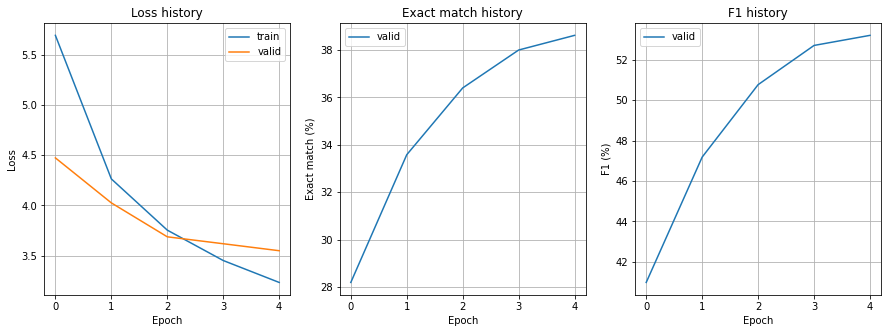

In [58]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['em'], label='valid')
axes[1].set_title('Exact match history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Exact match (%)')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['f1'], label='valid')
axes[2].set_title('F1 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

***Inference***

In [59]:
drqa.load_state_dict(torch.load('./checkpoints/DrQA.pth'))
drqa.to(DEVICE)

DrQA(
  (dropout): Dropout(p=0.3, inplace=False)
  (embedding): Embedding(26885, 300, padding_idx=1318)
  (align_question_embedding_layer): AlignQuestionEmbeddingLayer(
    (linear): Linear(in_features=300, out_features=300, bias=True)
  )
  (ctx_stacked_bi_lstm_layer): StackedBiLSTMsLayer(
    (dropout): Dropout(p=0.3, inplace=False)
    (lstms): ModuleList(
      (0): LSTM(604, 128, num_layers=3, batch_first=True, bidirectional=True)
      (1): LSTM(256, 128, num_layers=3, batch_first=True, bidirectional=True)
      (2): LSTM(256, 128, num_layers=3, batch_first=True, bidirectional=True)
    )
  )
  (qst_encoding_layer): QuestionEncodingLayer(
    (stacked_bilstms_layer): StackedBiLSTMsLayer(
      (dropout): Dropout(p=0.3, inplace=False)
      (lstms): ModuleList(
        (0): LSTM(300, 128, num_layers=3, batch_first=True, bidirectional=True)
        (1): LSTM(256, 128, num_layers=3, batch_first=True, bidirectional=True)
        (2): LSTM(256, 128, num_layers=3, batch_first=True, bid

In [60]:
def inference(model: nn.Module, context: spacy.tokens.doc.Doc, question: spacy.tokens.doc.Doc,
              text_vocab: Vocab, pos_vocab: Vocab, ner_vocab: Vocab, device: torch.device):
    # Build extra features
    question = [token.text.lower() for token in question]
    counts = collections.Counter(map(lambda token: token.text.lower(), context))
    freqs = {index: counts[token.text.lower()] for index, token in enumerate(context)}
    freqs_norm = sum(freqs.values())
    em, pos, ner, ntf = zip(
        *map(lambda index: [
            context[index].text.lower() in question, context[index].tag_,
            context[index].ent_type_ or 'None',
            freqs[index] / freqs_norm
        ], range(len(context)))
    )

    # Build tensors
    ctx = torch.LongTensor([*map(lambda word: text_vocab.stoi(word), context)]).unsqueeze(0).to(device)
    qst = torch.LongTensor([*map(lambda word: text_vocab.stoi(word), question)]).unsqueeze(0).to(device)
    len_ctx = torch.LongTensor([len(context)]).to(device)
    len_qst = torch.LongTensor([len(question)]).to(device)
    em = torch.LongTensor(em).unsqueeze(0).to(device)
    pos = torch.LongTensor([*map(lambda x: pos_vocab.stoi(x), pos)]).unsqueeze(0).to(device)
    ner = torch.LongTensor([*map(lambda x: ner_vocab.stoi(x), ner)]).unsqueeze(0).to(device)
    ntf = torch.LongTensor(ntf).unsqueeze(0).to(device)

    # Prediction
    model.eval()
    with torch.no_grad():
        # Feed the model
        start, end = model(ctx_sequences=ctx, ctx_lengths=len_ctx, qst_sequences=qst, qst_lengths=len_qst,
                           em_sequences=em, pos_sequences=pos, ner_sequences=ner, ntf_sequences=ntf)
    
        # Decode the result indexes
        start_index, end_index, proba = model.__class__.decode(starts=F.softmax(start, dim=-1), ends=F.softmax(end, dim=-1))

        # Extract the answer
        answer = context[start_index[0]:end_index[0] + 1]

    return answer, proba[0]

In [62]:
for index in np.random.choice(len(valid_qas), size=25, replace=False):
    id = valid_qas[index]['id']
    context = valid_qas[index]['context']
    question = valid_qas[index]['question']

    answers = []
    for qa in valid_qas:
        if id == qa['id']:
            answers.append(qa['answer'])

    prediction, proba = inference(model=drqa, context=context, question=question,
                                  text_vocab=TEXT, pos_vocab=POS, ner_vocab=NER, device=DEVICE)
    
    html = f'<p><span><b>Context:</b> {context.text}</span><br />'
    html += f'<span><b>Question:</b> {question.text}</span><br />'
    html += f'<span style="color:blue"><b>Possible answers:</b><br /><ul>'
    for answer in answers:
        html += f'<li style="color:blue">{answer.text}</li>'
    html += '</ul></span><br />'
    html += f'<span style="color:green"><b>Prediction:</b> {prediction}</span><br />'
    html += f'<span style="color:green"><b>Probability:</b> {proba * 100:.3f}%</span><br />'
    display(HTML(html))
    print('='*100)